#  COVID-19 Detection from X-Ray Images

## Project: Automatic pneumonia detection

---

In this notebook is used for automatic pneumonia detection using scratch Convolutional Neural Networks Model and ResNet50

In [42]:
import numpy as np
from glob import glob
from PIL import Image
import torchvision.transforms as transforms
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline    

# Load neumonia files
pneumnia_files = np.array(glob("chest_xray/*/*/*"))


# print number of images in the dataset
print('There are %d total dog images.' % len(pneumnia_files))

There are 5856 total dog images.


In [43]:
import torch
import torchvision.models as models

# check if CUDA is available
use_cuda = torch.cuda.is_available()


In [44]:
torch.cuda.is_available()

True

---
<a id='step3'></a>
## Creation of CNN to Classify Pneumonia (from Scratch)

This part create a CNN that classifies pneumonia. The task of assigning pneumonia from images is considered exceptionally challenging *even a human* would have trouble distinguishing between the images.


Below code separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `chest_xray/train`, `chest_xray/valid`, and `chest_xray/test`, respectively). Applied some augmenting training and validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [134]:
import os
from torchvision import datasets

## transforms, and batch_sizes
data_dir = "./chest_xray"
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
val_dir = os.path.join(data_dir, 'test/')

data_transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                     transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_transform_evaluation = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform_train)
test_data = datasets.ImageFolder(test_dir, transform=data_transform_evaluation)
val_data = datasets.ImageFolder(val_dir, transform=data_transform_evaluation)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
print('Num val images: ', len(val_data))

# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_scratch ={}
loaders_scratch["train"]=train_loader
loaders_scratch["valid"]=val_loader
loaders_scratch["test"]=test_loader


Num training images:  5216
Num test images:  624
Num val images:  624


### Model Architecture

Creation of CNN to classify pneuomia. 

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1= nn.Conv2d(3,16,3,padding=1)
        self.conv2= nn.Conv2d(16,32,3,padding=1)
        self.conv3= nn.Conv2d(32,64,3,padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1= nn.Linear(64*28*28,500)
        self.fc2= nn.Linear(500,2)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        ## Define forward behavior
        x= F.relu(self.bn1(self.conv1(x)))
        x= self.pool(x)
        x= F.relu(self.bn2(self.conv2(x)))
        x= self.pool(x)
        x= F.relu(self.bn3(self.conv3(x)))
        x= self.pool(x)
        x= x.view(-1, 64 * 28 * 28)
        x= self.dropout(x)
        x= F.relu(self.fc1(x))
        x= self.dropout(x)
        x= self.fc2(x)
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

### Specify Loss Function and Optimizer

Specification of a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Saved the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` .

In [12]:
import torch.optim as optim

### loss function
criterion_scratch = nn.CrossEntropyLoss()
### optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### Train and Validate the Model

Train and validate the model in the code cell below.  [Saved the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [13]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += (1 / (batch_idx + 1)) * (loss.data - train_loss)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += (1 / (batch_idx + 1)) * (loss.data - valid_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss   
            
    # return trained model
    return model


# train the model
model_scratch = train(1, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')



Epoch: 1 	Training Loss: 0.484603 	Validation Loss: 0.741723
Validation loss decreased (inf --> 0.741723).  Saving model ...


In [14]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

### Evaluation of the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [15]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.815327


Test Accuracy: 66% (417/624)


---
<a id='step4'></a>
## Creation of CNN to Classify Pneumonia (using Transfer Learning with ResNet 50)

Use of transfer learning to create a CNN that can identify pneumonia from images.  


In [45]:
## Specify data loaders
loaders_transfer=loaders_scratch

### Model Architecture

Use transfer learning to create a CNN to classify pneumonia. 

In [46]:
import torchvision.models as models
import torch.nn as nn

## model architecture 
model_transfer = models.resnet50(pretrained=True)
print(model_transfer)
print(model_transfer.fc.in_features) 
print(model_transfer.fc.out_features) 

# Freeze training for all required layers
parameters = filter(lambda p: p.requires_grad,model_transfer.parameters())

for param in parameters:
    param.requires_grad = False
    
# Change the last layer of the VGG16 model
n_inputs = model_transfer.fc.in_features
n_classes = 2
last_layer = nn.Linear(n_inputs, n_classes)
model_transfer.fc = last_layer
model_transfer.add_module("softmax",nn.Softmax(dim=1))

# Move to gpu
if use_cuda:
    model_transfer = model_transfer.cuda()
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Specify Loss Function and Optimizer

Saved the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [47]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### Training and Validation of the Model

[Saved the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [62]:
# train the model
n_epochs = 50
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.282411 	Validation Loss: 0.441379
Validation loss decreased (inf --> 0.441379).  Saving model ...
Epoch: 2 	Training Loss: 0.273506 	Validation Loss: 0.459051
Epoch: 3 	Training Loss: 0.279495 	Validation Loss: 0.430709
Validation loss decreased (0.441379 --> 0.430709).  Saving model ...
Epoch: 4 	Training Loss: 0.271114 	Validation Loss: 0.459003
Epoch: 5 	Training Loss: 0.281228 	Validation Loss: 0.442305
Epoch: 6 	Training Loss: 0.270132 	Validation Loss: 0.409329
Validation loss decreased (0.430709 --> 0.409329).  Saving model ...
Epoch: 7 	Training Loss: 0.279536 	Validation Loss: 0.432842
Epoch: 8 	Training Loss: 0.278126 	Validation Loss: 0.415562
Epoch: 9 	Training Loss: 0.275685 	Validation Loss: 0.424529
Epoch: 10 	Training Loss: 0.269343 	Validation Loss: 0.425933
Epoch: 11 	Training Loss: 0.270530 	Validation Loss: 0.423487
Epoch: 12 	Training Loss: 0.280402 	Validation Loss: 0.452129
Epoch: 13 	Training Loss: 0.275987 	Validation Loss: 0.488991
E

In [63]:
# load the model that got the best validation accuracy 
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### Evaluation of the Model

Try out the model on the test dataset

In [135]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.409445


Test Accuracy: 83% (521/624)


### Predict pneumonia with the Model

In [136]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item for item in train_data.classes]

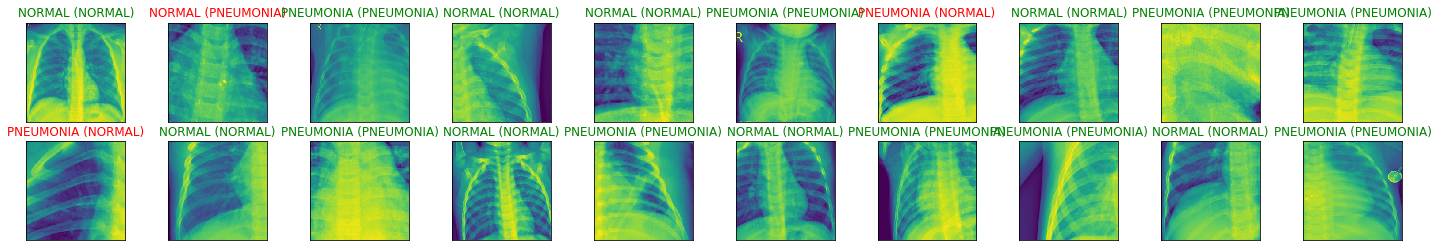

In [178]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = model_transfer(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Class predicted: NORMAL
Class actual: NORMAL


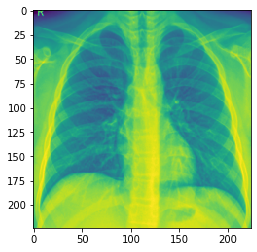

Class predicted: NORMAL
Class actual: PNEUMONIA


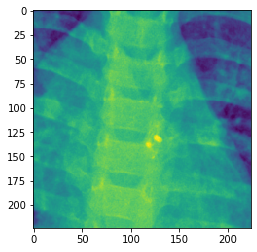

Class predicted: PNEUMONIA
Class actual: PNEUMONIA


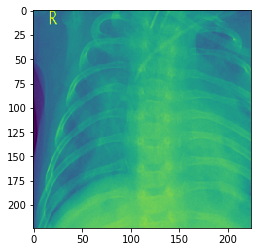

In [179]:
for idx in np.arange(3):
    print("Class predicted: "+str(class_names[preds[idx]]))
    print("Class actual: "+ str(class_names[labels[idx]]))
    plt.imshow(images[idx][0].cpu())
    plt.show()